# COSC401 Assignment 2
## Andrew French 
### ID: 11147452

Below is all of the libraries and modules needed for the entire program being imported. 
Make sure to run this step before running any of the feature code.

In [6]:
import numpy as np
import pandas as pd
import torch
import random

Below is all of the variables set that are global to the program.

In [2]:
np.random.seed(19680801)
plt.rcParams['figure.figsize'] = (10,5)

## Part 1 - Gradient-based Learning with Tensors

In [43]:
DATA_SIZE = 1000
RANDOM_STD_DEV = 0.01

In [47]:
def noiseFunction():
    return random.gauss(1, RANDOM_STD_DEV)

def ran_int():
    return random.randint(1, 100)

def inputFunc1(x1, x2, x4):
    return x1 + x2 - x4 + noiseFunction()

def inputFunc2(x2, x3):
    return x2 * 3 + x3 + noiseFunction()

def inputFunc3(x2, x4):
    return x2 + x4 + 2 + noiseFunction()

def inputFunc4(x1, x3):
    return (x1 - x3) * 2 + noiseFunction()

def inputFunc5(x1, x4):
    return (x4 + x1) - 6 + noiseFunction()

def modelFunc(x, w, b):
    """Performs matrix multiplication..."""
    return x @ w.t() + b

def mse(t1, t2):
    """Mean Squared Error loss function"""
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()
    

In [48]:
input_data_list = []
target_data_list = []

for i in range(DATA_SIZE):
    x1, x2, x3, x4 = ran_int(), ran_int(), ran_int(), ran_int()
    input_data_list.append([x1, x2, x3, x4])
    target_data_list.append([inputFunc1(x1, x2, x4), inputFunc2(x2, x3), inputFunc3(x2, x4), inputFunc4(x1, x3), 
                      inputFunc5(x1, x4)])
    
input_data = np.array(input_data_list, dtype='float32')
target_data = np.array(target_data_list, dtype='float32')

#Convert to tensors
inputs = torch.from_numpy(input_data)
targets = torch.from_numpy(target_data)

In [50]:
w = torch.randn(5, 4, requires_grad=True)
b = torch.randn(5, requires_grad=True)

print(f"Beginning gradient-based learning...")
preds = modelFunc(inputs, w, b)
loss = mse(preds, targets)

learning_rate = 1e-4
count = 0
while count < 1000000 and loss.item() > 0.04:
    preds = modelFunc(inputs, w, b)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad
        w.grad.zero_()
        b.grad.zero_()
    if count % 10000 == 0:
        print(f"Iteration: {count}, Loss {loss.item()}")
    count += 1
    
print(f"Learning finished.")

Iteration: 0, Loss 24602.76171875
Iteration: 10000, Loss 0.7094482779502869
Iteration: 20000, Loss 0.6653133034706116
Iteration: 30000, Loss 0.6239269375801086
Iteration: 40000, Loss 0.5851123332977295
Iteration: 50000, Loss 0.5487135648727417
Iteration: 60000, Loss 0.5145819783210754
Iteration: 70000, Loss 0.4825710952281952
Iteration: 80000, Loss 0.4525541067123413
Iteration: 90000, Loss 0.42440658807754517
Iteration: 100000, Loss 0.3980015218257904
Iteration: 110000, Loss 0.3732510209083557
Iteration: 120000, Loss 0.3500339090824127
Iteration: 130000, Loss 0.3282581865787506
Iteration: 140000, Loss 0.3078409731388092
Iteration: 150000, Loss 0.2886984348297119
Iteration: 160000, Loss 0.2707436680793762
Iteration: 170000, Loss 0.2539035677909851
Iteration: 180000, Loss 0.23811420798301697
Iteration: 190000, Loss 0.2233061045408249
Iteration: 200000, Loss 0.2094200700521469
Iteration: 210000, Loss 0.19639381766319275
Iteration: 220000, Loss 0.18419933319091797
Iteration: 230000, Loss 0

## Part 2 - Transfer Learning

All imports for this part of the question.

In [59]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import os
import copy

plt.ion()   # interactive mode

All Globals for Running the MNIST Training on its own

In [93]:
SEED = 1
MNIST_BATCH_SIZE = 100
CIFAR10_BATCH_SIZE = 300
LR = 0.005
MOMENTUM = 0.5
LOG_INTERVAL = 100
SAVE_MODEL = False
EPOCHS = 1

The functions to train and test a given model dataset

In [94]:
def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    accuracies = []
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        #Add to lists
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        #Accuracy
        total = target.size(0)
        _, predicted = torch.max(output.data, 1)
        correct = (predicted == target).sum().item()
        accuracies.append(correct / total)
        
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    return losses
    

            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

The Neural Network class for the Datasets

In [95]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [96]:
#MNIST
def trainAndTestMNIST():
    torch.manual_seed(SEED)

    device = torch.device("cpu")

    kwargs = {}

    mnist_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

    mnist_train_dataset = datasets.MNIST('../data', train=True, download=True,
                       transform=mnist_transforms)

    mnist_test_dataset = datasets.MNIST('../data', train=False, 
                       transform=mnist_transforms)

    mnist_train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=MNIST_BATCH_SIZE, shuffle=True, **kwargs)

    mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=MNIST_BATCH_SIZE, shuffle=True, **kwargs)


    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    #optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #epoch = EPOCHS
    for epoch in range(1, EPOCHS + 1):
        losses = train(model, device, mnist_train_loader, optimizer, epoch)
        test(model, device, mnist_test_loader)
    
    return model

In [97]:
#CIFAR10 
def trainAndTestCIFAR10(trainedModel=None):
    torch.manual_seed(SEED)

    device = torch.device("cpu")

    kwargs = {}

    cifar10_transforms = transforms.Compose([
                        transforms.CenterCrop(28),
                        transforms.Grayscale(num_output_channels=1),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

    cifar10_train_dataset = datasets.CIFAR10('../data', train=True, download=True,
                       transform=cifar10_transforms)

    cifar10_test_dataset = datasets.CIFAR10('../data', train=False, 
                       transform=cifar10_transforms)

    cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_dataset, batch_size=CIFAR10_BATCH_SIZE, shuffle=True, **kwargs)

    cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=CIFAR10_BATCH_SIZE, shuffle=True, **kwargs)

    model = Net().to(device)
    if trainedModel is not None:
        #Transfer over the trained layers
        model.conv1 = trainedModel.conv1
        model.conv2 = trainedModel.conv2

    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    #optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #epoch = EPOCHS
    for epoch in range(1, EPOCHS + 1):
        losses = train(model, device, cifar10_train_loader, optimizer, epoch)
        test(model, device, cifar10_test_loader)
    
    return losses


MNIST Data Train and Test
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307325
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.396828
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.630131
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.360468
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.203744
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.227798

Test set: Average loss: 0.2235, Accuracy: 9352/10000 (94%)

CIFAR10 Data Train and Test without Transfer Learning
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.305651
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2.286964

Test set: Average loss: 2.2687, Accuracy: 1594/10000 (16%)

CIFAR10 Data Train and Test with Transfer Learning
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.527988
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2.122441

Test set: Average loss: 2.0893, Accuracy: 2419/10000 (24%)



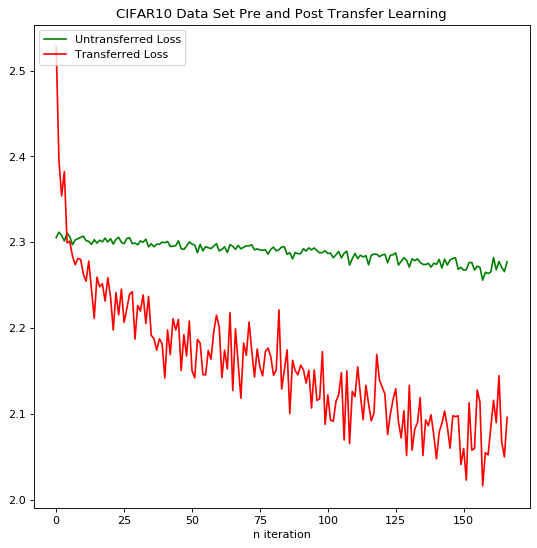

In [98]:
print("MNIST Data Train and Test")
mnist_model = trainAndTestMNIST()
print("CIFAR10 Data Train and Test without Transfer Learning")
non_transferred_losses = trainAndTestCIFAR10();
print("CIFAR10 Data Train and Test with Transfer Learning")
transferred_losses = trainAndTestCIFAR10(mnist_model);
    
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(non_transferred_losses, '-g', label='Untransferred Loss')
plt.plot(transferred_losses, '-r', label='Transferred Loss')

plt.xlabel("n iteration")
plt.legend(loc='upper left')
plt.title("CIFAR10 Data Set Pre and Post Transfer Learning")

plt.show()


This graph is used to display the loss before and after transfer learning.

## Part 3 - Small Research/Thinking Activity - Cost-Sensitive Learning

Suppose you are given a k-by-k cost matrix C for a classification task which
has k classes. The element Ci,j is the cost of classifying an instance of class j
as class i. You want to train a classifier that minimises the expected cost of
predictions. Do the following:
1. Write a pseudocode or Python code for a loss function that, once optimised
over all examples, achieves minimum expected cost of prediction.
2. Assuming that a learning algorithm which minimises the classification
error is given to you (and that you cannot supply your own loss function
to the algorithm), think and write about a different way of achieving
minimum expected cost of prediction.
Additional notes or requirements:
• Consider cases with k ≥ 2 and briefly discuss if the two methods are
scalable.
• You do not have to use tensors in this questions.
• If you choose to write in Python, you do not have to run your program
on any particular input. You can also use “pseudo-Python” if you wish.

### Part 3.2 - Achieving minimym expected cost of prediction
Idea: if you have a classifer with lots of data and one without, reduce the size of the data to match the smaller one.